# Recursive Bayesian Estimation

### Background Info
- https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation
- https://en.wikipedia.org/wiki/Particle_filter
- Good step-by-step breakdown of Bayes Filter math. https://johnwlambert.github.io/bayes-filter/
- Alpha-Beta filter. https://medium.com/@mathiasmantelli/kalman-filter-series-introduction-6d2e2b28d4cf
- Bayes filter. https://medium.com/@mathiasmantelli/kalman-filter-part-2-bayes-filter-f2fa9c0b5c95
- Kalman filter. https://medium.com/@mathiasmantelli/kalman-filter-part-3-a-formal-discussion-e1a61b359fef
- Particle filter 1. https://medium.com/@mathiasmantelli/particle-filter-part-1-introduction-fb6954bc12ec
- Particle filter 2. https://medium.com/@mathiasmantelli/particle-filter-part-2-intuitive-example-and-equations-0716223b862b
- Particle filter 3. https://medium.com/@mathiasmantelli/particle-filter-part-3-motion-and-measurement-models-be79857a5490
- Particle filter 4. https://medium.com/@mathiasmantelli/particle-filter-part-4-pseudocode-and-python-code-052a74236ba4

### Questions
- How does the computational demand of a particle filter scale with dimensions of the state space?
- How to get around having to explicitly define state parameters from observations?
- How does the entropy of state beliefs change compared to self-information of the observations?

### Table of Contents
1. Bayesian Update / Histogram Filter
2. Kalman Filter
3. Particle Filter / Sequential Monte Carlo / Monte Carlo Localization

### 1. Bayesian Update / Histogram Filter
This assumes no change in ground truth. No model of motion, no transition model. Stationary sensor, stationary target.
- Step 1: Observe
- Step 2: Update Beliefs

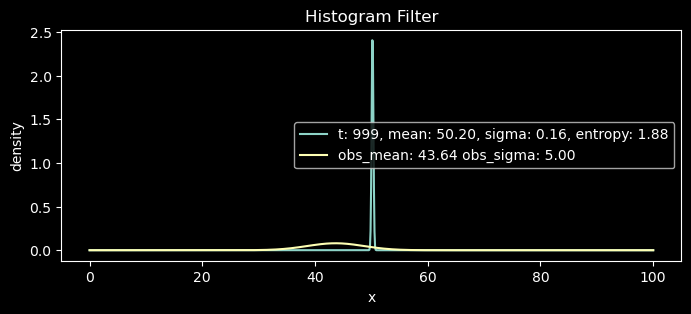

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, entropy
from IPython.display import clear_output

class HistogramFilter:
    def __init__(self):
        # Admin.
        self.title = 'Histogram Filter'
        
        # Initialize grid.
        self.x = np.linspace(0, 100, 1000)
        self.dx = self.x[1] - self.x[0]

        # Initialize belief distribution as unif(0, 100).
        self.belief = uniform.pdf(self.x, loc=0, scale=100)
        self.belief /= np.trapezoid(self.belief, self.x)  # normalize
        self.mean = np.trapezoid(self.belief * self.x, self.x)
        self.sigma = np.sqrt(np.trapezoid((self.x - self.mean)**2 * self.belief, self.x))
        self.entropy = entropy(self.belief)

    def generate_plot(self, t, obs_pdf, obs_mean, obs_sigma):
        clear_output(wait=True)
        plt.figure(figsize=(8, 3))
        plt.plot(self.x, self.belief, label=f't: {t}, mean: {self.mean:.2f}, sigma: {self.sigma:.2f}, entropy: {self.entropy:.2f}')
        plt.plot(self.x, obs_pdf, label=f'obs_mean: {obs_mean:.2f} obs_sigma: {obs_sigma:.2f}')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('density')
        plt.title(self.title)
        plt.show()

    def cycle(self, observations):
        
        for t, (obs_mean, obs_sigma) in enumerate(observations):

            # Step 1: generate pdf of observation.
            obs_pdf = norm.pdf(self.x, loc=obs_mean, scale=obs_sigma)

            # Step 2: Bayesian update: elementwise multiply, then normalize
            self.belief *= obs_pdf
            self.belief /= self.belief.sum() * self.dx # normalize
            self.mean = np.trapezoid(self.belief * self.x, self.x)
            self.sigma = np.sqrt(np.trapezoid((self.x - self.mean)**2 * self.belief, self.x))
            self.entropy = entropy(self.belief)

            # plot
            self.generate_plot(t, obs_pdf, obs_mean, obs_sigma)

histogram_filter = HistogramFilter()
observations = []
true_mean = 50
obs_sigma = 5

for t in range(1000):
    obs_mean = np.random.normal(true_mean, obs_sigma)
    observations.append((obs_mean, obs_sigma))

histogram_filter.cycle(observations)


    

- Because the observations and priors are Gaussian, the posterior is also Gaussian. 
- Additionally, the variance of the posterior distribution decreases no matter how improbable the observation! A feature, not a bug.
- Every observation decreases the belief's entropy. 

### 2. Kalman Filter

Same thing, but we add a transition model and a predictive step. Essentially, a there is a transition model and the model holds a belief of the first derivative of x. We assume linearity of the transition model and Gaussian. 

- Step 1: Predict
- Step 2: Observe
- Step 3: Update Beliefs


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, entropy
from IPython.display import clear_output

class KalmanFilter:
    def __init__(self):
        # Admin.
        self.title = 'Kalman Filter'
        
        # Initialize grid.
        self.x = np.linspace(0, 100, 1000)
        self.x_prime = np.linspace(0, 100, 1000)
        self.dx = self.x[1] - self.x[0]

        # Initialize belief distribution as [unif(0, 100); unif(0,100)].
        self.belief = np.array([uniform.pdf(self.x, loc=0, scale=100),  # x
                                uniform.pdf(self.x, loc=0, scale=100)])  # x_prime
        self.belief[0] /= np.trapezoid(self.belief[0], self.x)  # normalize x
        self.belief[1] /= np.trapezoid(self.belief[1], self.x_prime) # normalize x_prime

        # Stats for x
        self.x_mean = np.trapezoid(self.belief[0] * self.x, self.x)
        self.x_sigma = np.sqrt(np.trapezoid((self.x - self.mean)**2 * self.belief[0], self.x))
        self.x_entropy = entropy(self.belief[0])

        # Stats for x_prime
        self.x_prime_mean = np.trapezoid(self.belief[1] * self.x_prime, self.x_prime)
        self.x_prime_sigma = np.sqrt(np.trapezoid((self.x_prime - self.x_prime_mean)**2 * self.belief[1], self.x_prime))
        self.x_prime_entropy = entropy(self.belief[1])

        # Define transition matrix
        self.transition_matrix = np.array([[1, 1],  # dt = 1
                                           [0, 1]])

    def generate_plot(self, t, obs_pdf, obs_mean, obs_sigma):
        clear_output(wait=True)
        plt.figure(figsize=(8, 3))
        plt.plot(self.x, self.belief, label=f't: {t}, mean: {self.x_mean:.2f}, sigma: {self.x_sigma:.2f}, entropy: {self.x_entropy:.2f}')
        plt.plot(self.x, obs_pdf, label=f'obs_mean: {obs_mean:.2f} obs_sigma: {obs_sigma:.2f}')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('density')
        plt.title(self.title)
        plt.show()

    def cycle(self, observations):
        
        for t, (obs_mean, obs_sigma) in enumerate(observations):

            # Step 1: Predict next state based on linear transition model. 
            self.belief *= self.transition_matrix
            
            # Step 2: generate pdf of observation.
            obs_pdf = norm.pdf(self.x, loc=obs_mean, scale=obs_sigma)

            # Step 3: Bayesian update: elementwise multiply, then normalize.
            self.belief[0] *= obs_pdf
            self.belief[0] /= np.trapezoid(self.belief[0], self.x)  # normalize x
            self.mean = np.trapezoid(self.belief * self.x, self.x)
            self.sigma = np.sqrt(np.trapezoid((self.x - self.mean)**2 * self.belief, self.x))
            self.entropy = entropy(self.belief)

            # plot
            self.generate_plot(t, obs_pdf, obs_mean, obs_sigma)

kalman_filter = KalmanFilter()
observations = []
true_mean = 50
obs_sigma = 5

for t in range(1000):
    obs_mean = np.random.normal(true_mean, obs_sigma)
    observations.append((obs_mean, obs_sigma))

kalman_filter.cycle(observations)


    

AttributeError: 'KalmanFilter' object has no attribute 'mean'